# **VGG Network**
2023-01-31

1. Convolution Operation
2. VGG Network
3. Train CIFAR-10 with own VGG
4. Train CIFAR-10 with pre-trained VGG



## Import packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils import data
print(torch.__version__)
print(torch.cuda.is_available())

1.13.1+cu116
True


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# 1. Convolution Operation

PyTorch에서는 [nn.sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) 등의 함수를 이용해서 복잡한 모델 구조를 종종 축약해서 사용한다.

In [ ]:
input_image = torch.rand(64, 3, 32, 32)
input_image.shape

torch.Size([64, 3, 32, 32])

### nn.Sequential

In [ ]:
class Conv1(nn.Module):
    def __init__(self): # input image = batch_size x 3 x 32 x 32
        super(Conv1, self).__init__()
        self.conv = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x


class Conv2(nn.Module):
    def __init__(self): # input image = batch_size x 3 x 32 x 32
        super(Conv2, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))

    def forward(self, x):
        x = self.layer(x)
        return x


class Conv3(nn.Module):
    def __init__(self): # input image = batch_size x 3 x 32 x 32
        super(Conv3, self).__init__()
        layer = []
        layer.append(nn.Conv2d(3, 64, kernel_size=3, padding=1))
        layer.append(nn.ReLU())
        layer.append(nn.MaxPool2d(2))
        self.layer = nn.Sequential(*layer)

    def forward(self, x):
        x = self.layer(x)
        return x

model1 = Conv1()
model2 = Conv2()
model3 = Conv3()

In [ ]:
print(model1)
output = model1(input_image)
print(output.size())

Conv1(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([64, 64, 16, 16])


In [ ]:
print(model2)
output = model2(input_image)
print(output.size())

Conv2(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([64, 64, 16, 16])


In [ ]:
print(model3)
output = model3(input_image)
print(output.size())

Conv3(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([64, 64, 16, 16])


### calculate the shape of the network

In [ ]:
import math
def out_size(in_s, pad_s, ker_s, str_s):
  return math.floor((in_s + 2*(pad_s) - ker_s)/(str_s) + 1)


i = out_size(32, 1, 3, 1)
print(i)
i = out_size(i, 1, 3, 1)
print(i)
i = out_size(i, 1, 3, 2)
print(i)
i = out_size(i, 1, 3, 4)
print(i)

32
32
16
4


In [ ]:
class Conv(nn.Module):
    def __init__(self): # input image = batch_size x 3 x 32 x 32
        super(Conv, self).__init__()
        
        # input_channel_size, output_channel_size, kernel_size, stride, padding
        self.conv1 = nn.Conv2d(3, 512, 3, 1, 1) 
        self.conv2 = nn.Conv2d(512, 256, 3, 1, 1) 
        self.conv3 = nn.Conv2d(256, 256, 3, 2, 1) 
        ## linear layer의 shape에 맞게 convolution layer의 configuration을 setting
        self.conv4 = nn.Conv2d(256, 256, 3, 4, 1)
        self.linear = nn.Linear(256*4*4, 10)

    def forward(self, x):
        out=self.conv1(x)
        out=self.conv2(out)
        out=self.conv3(out)
        out=self.conv4(out)
        out = out.contiguous().view(-1, 256*4*4)
        out = self.linear(out)
        return out

In [ ]:
model = Conv()
print(model)
output = model(input_image)
print(output.size())

Conv(
  (conv1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
  (linear): Linear(in_features=4096, out_features=10, bias=True)
)
torch.Size([64, 10])


# 2. VGG Network
19-layer VGG-network

자세한 모델의 configuration은 아래 그림의 option E와 같다.

VGG-19는 
1. 2-layer로 구성된 2개의 convolution block
2. 4-layer로 구성된 3개의 convolution block 

으로 나누어져있다.

또한, 학습 안정성을 위하여 각 layer는 **convolution -> batch-norm -> ReLU**로 이루어지게 되며 매 block에 끝마다 2*2 max pooling을 진행한다. 



In [ ]:
class TwoLayerBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TwoLayerBlock, self).__init__()
        self.in_dim = input_dim
        self.out_dim = output_dim
        self.layer = nn.Sequential(nn.Conv2d(self.in_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2)
                                 )
        
    def forward(self, x):
        x = self.layer(x)
        return x

In [ ]:
class FourLayerBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FourLayerBlock, self).__init__()
        self.in_dim = input_dim
        self.out_dim = output_dim
        self.layer = nn.Sequential(nn.Conv2d(self.in_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2)
                                 )
        
    def forward(self, x):
        x = self.layer(x)
        return x

In [ ]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        
        self.block1 = TwoLayerBlock(3, 64)
        self.block2 = TwoLayerBlock(64, 128)
        self.block3 = FourLayerBlock(128, 256)
        self.block4 = FourLayerBlock(256, 512)
        self.block5 = FourLayerBlock(512, 512)
        self.linear = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = x.squeeze() 
        x = self.linear(x)
        return x

In [ ]:
model = VGG19()
print(model)

output = model(input_image)
print(output.size())

VGG19(
  (block1): TwoLayerBlock(
    (layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block2): TwoLayerBlock(
    (layer): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2,

### Check Implementations

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
if count_parameters(model) == 20365002:
    print('success!')
else:
  raise AssertionError

success!


# 3. Train CIFAR-10 with own VGG

train-image: 50,000
test-image: 10,000

class: [비행기, 자동차, 트럭, 개구리, ...] 등 10개의 class

for more info, https://www.cs.toronto.edu/~kriz/cifar.html

### Use pre-defined dataset

cifar-10은 pre-defined된 dataset이므로 dataloader 과정이 필요하지 않음

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

train_dataset = datasets.CIFAR10(root='./data/',      
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

test_dataset = datasets.CIFAR10(root='./data/',
                                train=False, 
                                transform=transforms.ToTensor())

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/


In [ ]:
class Trainer():
    def __init__(self, trainloader, testloader, model, optimizer, criterion, device):
        """
        trainloader: train data's loader
        testloader: test data's loader
        model: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        
    def train(self, epoch = 1):
        self.model.train()
        loss_list = []
        acc_list = []
        for e in range(epoch):
            running_loss, running_acc = 0.0, 0.0
            for i, data in tqdm.tqdm(enumerate(self.trainloader, 0)): 
                inputs, labels = data 
                # model에 input으로 tensor를 gpu-device로 보낸다
                inputs = inputs.to(self.device)  
                labels = labels.to(self.device)
                # zero the parameter gradients
                self.optimizer.zero_grad()    
                # forward + backward + optimize
                outputs = self.model(inputs) 
                loss = self.criterion(outputs, labels)  
                loss.backward() 
                self.optimizer.step() 
                running_loss += loss.item()
                pred = outputs.max(1, keepdim=True)[1]
                running_acc += pred.eq(labels.view_as(pred)).sum().item()
            
            running_loss = running_loss / len(self.trainloader)
            running_acc = running_acc / len(self.trainloader.dataset)
            loss_list.append(running_loss)
            acc_list.append(running_acc)
            print('epoch: %d  loss: %.3f  acc:%.3f' % (e + 1, running_loss, running_acc))
            
        return loss_list, acc_list

    def test(self):
        self.model.eval() 
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            output = self.model(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()
        test_acc = correct / len(self.testloader.dataset)
        print('test_acc: %.3f' %(test_acc))

In [ ]:
model = VGG19()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda')
model.to(device)

VGG19(
  (block1): TwoLayerBlock(
    (layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block2): TwoLayerBlock(
    (layer): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2,

In [ ]:
trainer = Trainer(trainloader = train_loader,
                  testloader = test_loader,
                  model = model,
                  criterion = criterion,
                  optimizer = optimizer,
                  device = device)

loss_list, acc_list = trainer.train(epoch = 10)

782it [00:51, 15.20it/s]


epoch: 1  loss: 1.313  acc:0.523


782it [00:43, 17.84it/s]


epoch: 2  loss: 0.860  acc:0.698


782it [00:43, 18.04it/s]


epoch: 3  loss: 0.663  acc:0.773


782it [00:43, 18.05it/s]


epoch: 4  loss: 0.527  acc:0.820


782it [00:43, 17.99it/s]


epoch: 5  loss: 0.411  acc:0.862


782it [00:43, 17.97it/s]


epoch: 6  loss: 0.325  acc:0.891


782it [00:43, 18.04it/s]


epoch: 7  loss: 0.258  acc:0.913


782it [00:43, 18.05it/s]


epoch: 8  loss: 0.211  acc:0.931


782it [00:43, 18.06it/s]


epoch: 9  loss: 0.176  acc:0.942


782it [00:43, 18.08it/s]

epoch: 10  loss: 0.148  acc:0.952


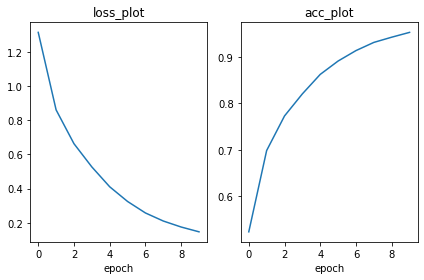

In [ ]:
x = np.arange(10)

fig, axs = plt.subplots(1, 2)
axs[0].plot(x, loss_list)
axs[0].set_xlabel('epoch')
axs[0].set_title('loss_plot')

axs[1].plot(x, acc_list)
axs[1].set_xlabel('epoch')
axs[1].set_title('acc_plot')

plt.tight_layout()
plt.show()

In [ ]:
trainer.test()

test_acc: 0.814


### over-fitting으로 인해 test-accuracy가 train-accuracy에 비해 현저히 낮은 성능을 보인다.


# 4. Train CIFAR-10 with pre-trained VGG

pre-trained된 VGG model을 불러와서 linear layer만 추가적으로 학습

PyTorch에서 공식적으로 제공하는 pre-trained model은 https://pytorch.org/vision/stable/models.html 해당 document에서 찾아볼 수 있다.

개발한 모델에 대한 pre-trained weight : https://github.com/google-research/simclr

In [ ]:
import torchvision.models as models
pretrained_vgg = models.vgg19_bn(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
class Pretrained_VGG19(nn.Module):
    def __init__(self, pretrained_model):
        super(Pretrained_VGG19, self).__init__()
        # inherit the weights from the pre-trained model
        self.features = nn.Sequential(
            *list(pretrained_model.features.children())
        )
        self.linear = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.squeeze() 
        x = self.linear(x)
        return x

In [ ]:
model = Pretrained_VGG19(pretrained_vgg)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda')
model.to(device)

Pretrained_VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Co

In [ ]:
trainer = Trainer(trainloader = train_loader,
                  testloader = test_loader,
                  model = model,
                  criterion = criterion,
                  optimizer = optimizer,
                  device = device)

loss_list, acc_list = trainer.train(epoch = 1)

782it [00:46, 16.64it/s]


epoch: 1  loss: 0.242  acc:0.921


In [ ]:
trainer.test()

test_acc: 0.877


In [ ]:
trainer_10e = Trainer(trainloader = train_loader,
                  testloader = test_loader,
                  model = model,
                  criterion = criterion,
                  optimizer = optimizer,
                  device = device)

loss_list, acc_list = trainer_10e.train(epoch = 10)

782it [00:43, 18.10it/s]


epoch: 1  loss: 0.142  acc:0.953


782it [00:42, 18.23it/s]


epoch: 2  loss: 0.098  acc:0.968


782it [00:42, 18.21it/s]


epoch: 3  loss: 0.076  acc:0.975


782it [00:42, 18.21it/s]


epoch: 4  loss: 0.056  acc:0.981


782it [00:42, 18.23it/s]


epoch: 5  loss: 0.053  acc:0.983


782it [00:42, 18.23it/s]


epoch: 6  loss: 0.049  acc:0.984


782it [00:42, 18.22it/s]


epoch: 7  loss: 0.042  acc:0.987


782it [00:43, 18.18it/s]


epoch: 8  loss: 0.039  acc:0.987


782it [00:42, 18.19it/s]


epoch: 9  loss: 0.036  acc:0.988


782it [00:42, 18.24it/s]

epoch: 10  loss: 0.033  acc:0.989


In [ ]:
trainer_10e.test()

test_acc: 0.891


Pre-trained된 Parameter를 사용한 모델의 성능이 뛰어나다.